<a href="https://colab.research.google.com/github/vcsk02/CMPE258-Assignment1/blob/main/CMPE258_Assignment1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free‑friendly Multimodal Demo (Colab)
## Gemini 2.5 Flash (cheap) + Replicate “Try for Free” (image + video) + optional Groq (free text)

This notebook is designed for a **YouTube demo + GitHub outputs** without blowing through credits.

**Flow**
1) **Text → text**: “interesting conversation hints”  
   - Prefer **Gemini 2.5 Flash** (cheap); fallback to **Groq** (free tier) if you want  
2) **Text → image**: generate a striking image using Replicate **Try for Free** model **`google/imagen-4`**  
3) **Image → interesting info**: analyze the image with **Gemini 2.5 Flash** (multimodal understanding)  
4) **Image → video**: animate into a short clip using Replicate **Try for Free** model **`minimax/video-01`**

All artifacts are saved in `outputs/` so you can upload them to GitHub.

> Heads‑up: Gemini **image generation** and **Veo** video are paid-only. This notebook avoids that by using Replicate’s Try‑for‑Free models for image/video generation.


## 0) Install + folders

In [1]:
%pip -q install --upgrade google-genai pillow replicate groq requests

import pathlib
pathlib.Path("outputs").mkdir(parents=True, exist_ok=True)
print("✅ Installed. outputs/ is ready.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.1.1 which is incompatible.
✅ Installed. outputs/ is ready.


## 1) API keys (paste once per session)

You can run:
- **Gemini 2.5 Flash** with `GEMINI_API_KEY` (text + image understanding)
- **Replicate Try for Free** with `REPLICATE_API_TOKEN` (image + video generation)
- Optional: **Groq** with `GROQ_API_KEY` (free text model, e.g. DeepSeek R1 Distill)

**Important:** never commit keys to GitHub.


In [2]:
import os, getpass

# Gemini (optional but recommended for image understanding + cheap text)
if not os.environ.get("GEMINI_API_KEY"):
    os.environ["GEMINI_API_KEY"] = getpass.getpass("Paste GEMINI_API_KEY (hidden; press Enter to skip): ").strip()

# Replicate (needed for Try-for-Free image + video)
if not os.environ.get("REPLICATE_API_TOKEN"):
    os.environ["REPLICATE_API_TOKEN"] = getpass.getpass("Paste REPLICATE_API_TOKEN (hidden): ").strip()

# Groq (optional fallback for text-only)
if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = getpass.getpass("Paste GROQ_API_KEY (hidden; press Enter to skip): ").strip()

print("✅ Keys loaded (not printing them).")


Paste GEMINI_API_KEY (hidden; press Enter to skip): ··········
Paste REPLICATE_API_TOKEN (hidden): ··········
Paste GROQ_API_KEY (hidden; press Enter to skip): ··········
✅ Keys loaded (not printing them).


## 2) Clients + model IDs

In [3]:
import os
from google import genai
from google.genai import types

GEMINI_TEXT_MODEL = "gemini-2.5-flash"  # low-credit text + multimodal understanding
# (We do NOT use Gemini image generation here to avoid paid-only limits.)

# Replicate Try-for-Free models
REPLICATE_IMAGE_MODEL = "google/imagen-4"
REPLICATE_VIDEO_MODEL = "minimax/video-01"

gemini_client = None
if os.environ.get("GEMINI_API_KEY"):
    gemini_client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
    print("✅ Gemini client ready:", GEMINI_TEXT_MODEL)
else:
    print("⚠️ GEMINI_API_KEY not set. Text+vision steps will be skipped or limited.")

# Replicate uses env var REPLICATE_API_TOKEN automatically
import replicate
print("✅ Replicate client ready:", REPLICATE_IMAGE_MODEL, "and", REPLICATE_VIDEO_MODEL)

# Optional Groq (text-only)
groq_client = None
if os.environ.get("GROQ_API_KEY"):
    from groq import Groq
    groq_client = Groq(api_key=os.environ["GROQ_API_KEY"])
    print("✅ Groq client ready (text-only).")
else:
    print("ℹ️ GROQ_API_KEY not set. (That's fine.)")


✅ Gemini client ready: gemini-2.5-flash
✅ Replicate client ready: google/imagen-4 and minimax/video-01
✅ Groq client ready (text-only).


## 3) Helper utilities

In [4]:
import base64, io, pathlib, requests
from PIL import Image

OUT = pathlib.Path("outputs")
OUT.mkdir(parents=True, exist_ok=True)

def save_text(name: str, text: str) -> str:
    p = OUT / name
    p.write_text(text, encoding="utf-8")
    return str(p)

def image_to_data_url(img: Image.Image, fmt="PNG") -> str:
    buf = io.BytesIO()
    img.save(buf, format=fmt)
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return f"data:image/{fmt.lower()};base64,{b64}"

def replicate_output_to_bytes(output) -> bytes:
    # Replicate output may be:
    # - FileOutput with .read()
    # - list/tuple of FileOutput or URLs
    # - a single URL string
    if output is None:
        raise RuntimeError("Replicate returned None output")

    if hasattr(output, "read"):
        return output.read()

    if isinstance(output, (list, tuple)) and len(output) > 0:
        item = output[0]
        if hasattr(item, "read"):
            return item.read()
        if isinstance(item, str):
            r = requests.get(item, timeout=120)
            r.raise_for_status()
            return r.content

    if isinstance(output, str):
        r = requests.get(output, timeout=120)
        r.raise_for_status()
        return r.content

    raise TypeError(f"Unsupported Replicate output type: {type(output)}")

def save_bytes(path: str, data: bytes) -> str:
    p = OUT / path
    p.write_bytes(data)
    return str(p)


## 4) Text → Text (Gemini Flash preferred, Groq optional)

This cell generates “interesting conversation hints” for your demo.


In [5]:
topic = "Start a friendly conversation about AI and creativity without sounding like a robot."

def gemini_text(prompt: str) -> str:
    resp = gemini_client.models.generate_content(
        model=GEMINI_TEXT_MODEL,
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=0.7,
            system_instruction=(
                "You are a conversation coach. "
                "Give: (1) a suggested reply (1-2 sentences), "
                "(2) 3 follow-up questions, "
                "(3) one accurate surprising fun fact. "
                "Be concise and not cringe."
            ),
        ),
    )
    return resp.text

def groq_text(prompt: str) -> str:
    completion = groq_client.chat.completions.create(
        model="deepseek-r1-distill-llama-70b",
        messages=[{"role":"user","content": prompt}],
        temperature=0.6,
    )
    return completion.choices[0].message.content

if gemini_client:
    out = gemini_text(topic)
    engine = "Gemini 2.5 Flash"
elif groq_client:
    out = groq_text(topic)
    engine = "Groq (DeepSeek R1 Distill)"
else:
    raise RuntimeError("No text model key set. Set GEMINI_API_KEY or GROQ_API_KEY.")

print(f"=== Using: {engine} ===\n")
print(out)
save_text("conversation_hints.md", out)
print("\n✅ Saved outputs/conversation_hints.md")


=== Using: Gemini 2.5 Flash ===

Here's a way to get that conversation started:

**Suggested Reply:**
"Hey, I was just thinking about all the AI art and music popping up lately. It really makes you wonder about the future of human creativity, doesn't it?"

**3 Follow-up Questions:**
1.  Do you see AI as more of a powerful tool for artists, or a potential competitor?
2.  What's one creative field where you think AI will struggle most to genuinely replicate human touch?
3.  Have you ever tried using an AI tool for something creative yourself, or seen a piece of AI art that really impressed you?

**Surprising Fun Fact:**
An AI once wrote a short film screenplay called "Sunspring," starring Thomas Middleditch, which was actually produced and premiered at a film festival.

✅ Saved outputs/conversation_hints.md


## 5) Text → Image (Replicate Try-for-Free): `google/imagen-4`

We generate an interesting image from a prompt and save it to:
- `outputs/generated_image.jpg`


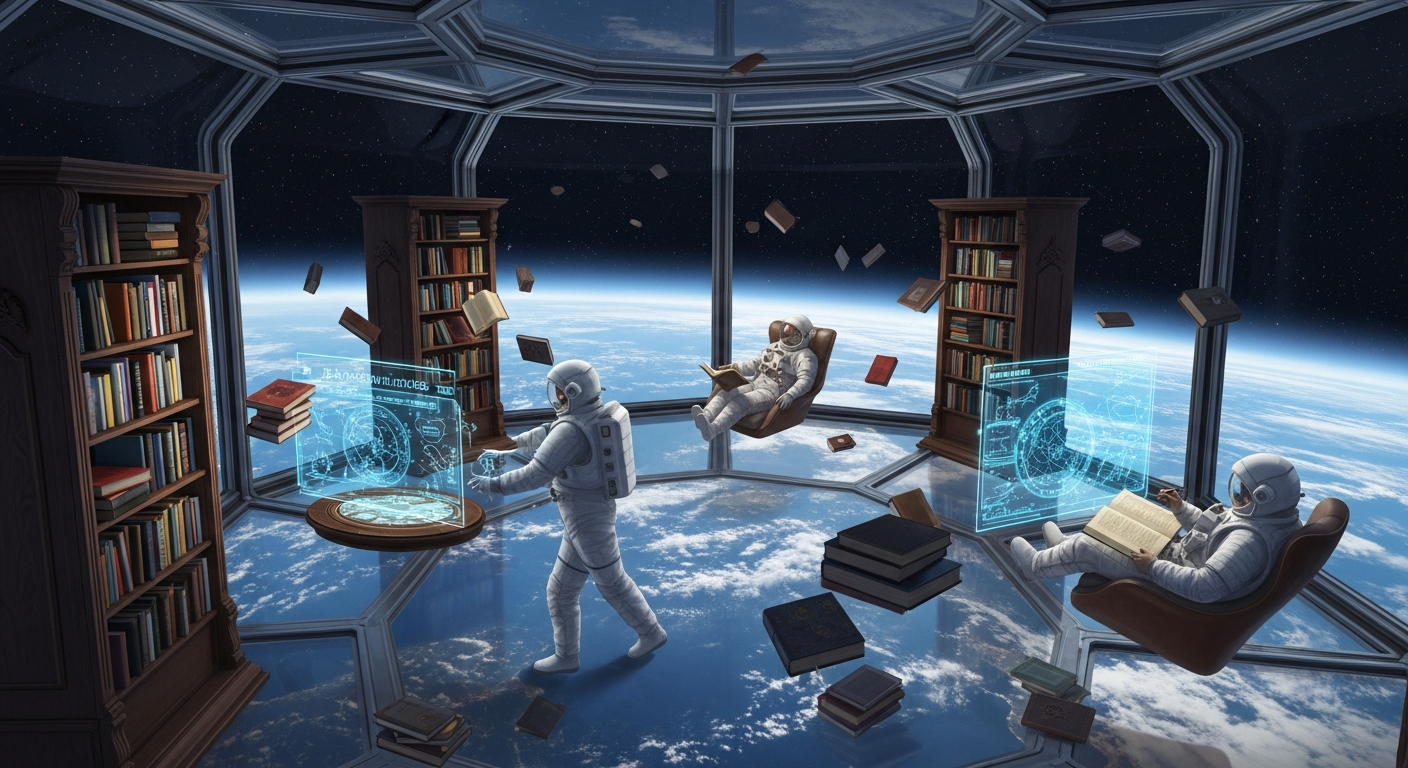

✅ Saved: outputs/generated_image.jpg


In [6]:
import io
from PIL import Image

prompt = (
    "A surreal, cinematic wide shot of a quiet library floating in low orbit above Earth. "
    "Warm golden reading lamps glow through glass walls. Astronauts drift between shelves. "
    "Ultra-detailed, realistic lighting, gentle depth of field. No text."
)

# Imagen 4 schema includes: prompt, image_size, aspect_ratio, output_format, safety_filter_level
rep_out = replicate.run(
    REPLICATE_IMAGE_MODEL,
    input={
        "prompt": prompt,
        "image_size": "1K",
        "aspect_ratio": "16:9",
        "output_format": "jpg",
        "safety_filter_level": "block_only_high",
    },
)

img_bytes = replicate_output_to_bytes(rep_out)
img_path = save_bytes("generated_image.jpg", img_bytes)
img = Image.open(io.BytesIO(img_bytes))
display(img)
print("✅ Saved:", img_path)


## 6) Image → Interesting info (Gemini 2.5 Flash multimodal)

We send the generated image back into Gemini and ask for:
- short description
- 8 specific details
- 3 accurate science/space facts
- 3 improved prompts for even cooler images/videos


In [7]:
from PIL import Image

if not gemini_client:
    raise RuntimeError("This step needs GEMINI_API_KEY (Gemini Flash can do multimodal understanding).")

img = Image.open(OUT / "generated_image.jpg")

analysis_prompt = """Look at this image and do ALL of the following:
1) Describe the scene in 2-3 sentences.
2) List 8 interesting details you notice (be specific).
3) Give 3 short, accurate science/space facts that relate to the scene.
4) Suggest 3 improved prompts to generate an even cooler version of this image.
"""

resp = gemini_client.models.generate_content(
    model=GEMINI_TEXT_MODEL,
    contents=[img, analysis_prompt],
    config=types.GenerateContentConfig(temperature=0.5),
)

print(resp.text)
save_text("image_insights.md", resp.text)
print("\n✅ Saved outputs/image_insights.md")


Here's an analysis of the image:

1)  **Description of the scene:**
    The image depicts a breathtaking scene inside a futuristic space station library, orbiting high above Earth. Astronauts in full suits are engaged in various intellectual pursuits, surrounded by traditional wooden bookshelves and numerous floating books, all set against a stunning panoramic view of the blue planet and the starry expanse of space.

2)  **8 interesting details you notice:**
    *   Three astronauts are present; one is interacting with a holographic display, another is reading a physical book while floating in a chair, and a third is walking/floating.
    *   Numerous books are suspended in mid-air throughout the room, a clear indication of zero gravity.
    *   The library features several ornate, traditional wooden bookshelves filled with books, contrasting with the high-tech, space environment.
    *   Large, panoramic windows form the walls and ceiling of the room, offering an expansive view of Ear

## 7) Image → Video (Replicate Try-for-Free): `minimax/video-01`

We animate the generated image into a short video and save:
- `outputs/generated_video.mp4`

> If your “Try for Free” runs are exhausted, Replicate will ask you to add billing.


In [8]:
import io
from PIL import Image

img = Image.open(OUT / "generated_image.jpg")
first_frame = image_to_data_url(img, fmt="JPEG")

video_prompt = (
    "Slow cinematic pan across the floating orbital library. "
    "Dust motes shimmer in sunlight. Astronauts gently drift past shelves. "
    "Ultra-realistic, film look, subtle camera movement, no text."
)

rep_out = replicate.run(
    REPLICATE_VIDEO_MODEL,
    input={
        "prompt": video_prompt,
        "first_frame_image": first_frame,
        "prompt_optimizer": True,
    },
)

vid_bytes = replicate_output_to_bytes(rep_out)
vid_path = save_bytes("generated_video.mp4", vid_bytes)

print("✅ Saved:", vid_path)


✅ Saved: outputs/generated_video.mp4


## 8) Bundle outputs for GitHub

In [9]:
import shutil
zip_path = shutil.make_archive("outputs_bundle", "zip", "outputs")
print("✅ Created:", zip_path)
print("Colab: left sidebar → Files → download outputs_bundle.zip")


✅ Created: /content/outputs_bundle.zip
Colab: left sidebar → Files → download outputs_bundle.zip
